In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from kalman.dkf import DeepKalmanFilter
from kalman.dkf_learning import learn
from typing import Dict, Any
from kalman.gaussian import GaussianState

# Train

In [31]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# 1. Подготовка данных
def generate_synthetic_data(seq_len=100, n_samples=50, obs_dim=1):
    """Генерация синтетических данных (синусоида с шумом)"""
    t = torch.linspace(0, 4*np.pi, seq_len)
    signals = torch.sin(t) + 0.3*torch.sin(3*t)
    data = []
    for _ in range(n_samples):
        noise = torch.randn(seq_len) * 0.2
        data.append((signals + noise).unsqueeze(-1))
    return torch.stack(data)  # (n_samples, seq_len, obs_dim)

# Параметры данных
seq_len = 100
batch_size = 16
obs_dim = 1
state_dim = 2

# Генерация данных
train_data = generate_synthetic_data(seq_len, n_samples=100)
val_data = generate_synthetic_data(seq_len, n_samples=20)

# Создание DataLoader
train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_data), batch_size=batch_size)

# 2. Инициализация модели
params = {
    'dataset': 'real',
    'transition_type': 'mlp',
    'emission_type': 'mlp',
    'data_type': 'real',
    'dim_hidden': 32,
    'transition_layers': 2,
    'emission_layers': 2,
    'use_prev_input': True,
    'var_model': 'L',
    'rnn_size': 64,
    'rnn_layers': 1,
    'inference_model': 'structured'
}

model = DeepKalmanFilter(state_dim=state_dim, obs_dim=obs_dim, params=params)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 3. Функция обучения
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch[0].transpose(0, 1)  # (seq_len, batch, obs_dim)
        optimizer.zero_grad()
        
        # Генерация шума для репараметризации
        eps = torch.randn_like(batch).repeat(1, 1, state_dim)
        
        # Forward pass
        loss, nll, kl = model.loss(batch, torch.ones_like(batch[..., 0]), eps)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

# 4. Функция валидации
def validate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch[0].transpose(0, 1)
            eps = torch.randn_like(batch).repeat(1, 1, state_dim)
            loss, _, _ = model.loss(batch, torch.ones_like(batch[..., 0]), eps)
            total_loss += loss.item()
    return total_loss / len(loader)

# 5. Цикл обучения
n_epochs = 50
best_val_loss = float('inf')

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss = validate(model, val_loader)
    
    # Сохранение лучшей модели
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_dkf_model.pth')
    
    # Annealing KL divergence
    model.anneal = min(1.0, 0.01 + epoch / 10)
    
    print(f'Epoch {epoch+1}/{n_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Anneal: {model.anneal:.2f}')

# 6. Загрузка лучшей модели
model.load_state_dict(torch.load('best_dkf_model.pth'))

TypeError: GaussianState.__init__() missing 1 required positional argument: 'covariance'

In [25]:
params: Dict[str, Any] = {
    'dataset': 'real',
    'transition_type': 'simple_gated',  # Упростим для примера
    'emission_type': 'mlp',
    'data_type': 'real',
    'dim_hidden': 16,
    'transition_layers': 1,
    'emission_layers': 1,
    'use_prev_input': False,
    'var_model': 'L',  # Только forward LSTM
    'rnn_size': 32,
    'rnn_layers': 1,
    'inference_model': 'structured'
}

In [26]:
# 2. Создаем модель
state_dim = 2  # 2D латентное пространство для визуализации
obs_dim = 1    # 1D наблюдения
dkf = DeepKalmanFilter(state_dim=state_dim, obs_dim=obs_dim, params=params)

In [27]:
def generate_data(seq_len=100, batch_size=1):
    t = torch.linspace(0, 4*np.pi, seq_len)
    signal = torch.sin(t) + 0.5*torch.sin(3*t)
    noise = torch.randn(seq_len) * 0.2
    return (signal + noise).unsqueeze(0).unsqueeze(-1)  # (1, seq_len, 1)

observations = generate_data().transpose(0, 1)  # (seq_len, 1, 1)
observations = observations.transpose(0, 1)

# Plot example

In [28]:
# 4. Инференс
with torch.no_grad():
    all_means, all_covs = dkf(observations)
print(all_means.shape)
print(all_covs.shape)


torch.Size([1, 100, 2])
torch.Size([1, 100, 2])


Размерность means_np: (100, 2)
Размерность covs_np: (100, 2)


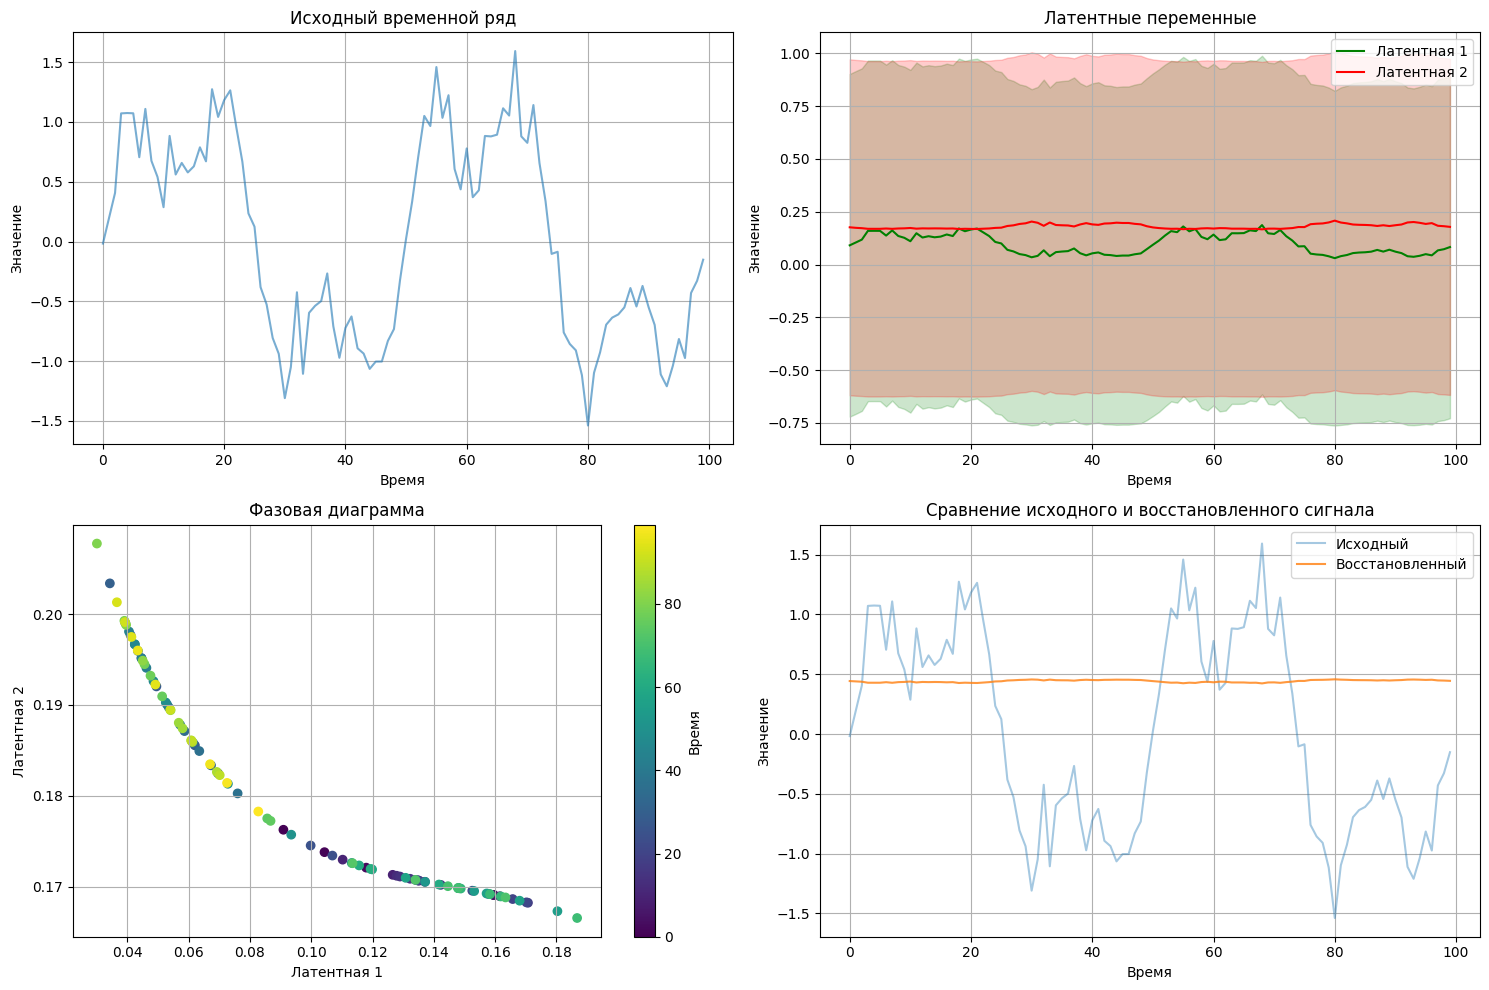

In [30]:
# 5. Визуализация
plt.figure(figsize=(15, 10))

# Преобразуем данные к numpy
obs_np = observations.squeeze().cpu().numpy()  # (seq_len,)
means_np = all_means.squeeze().cpu().numpy()  # (seq_len, state_dim)
covs_np = all_covs.squeeze().cpu().numpy()   # Проверим размерность

# Проверка размерностей
print("Размерность means_np:", means_np.shape)
print("Размерность covs_np:", covs_np.shape)

# График наблюдений
plt.subplot(2, 2, 1)
plt.plot(obs_np, label='Наблюдения', alpha=0.6)
plt.title("Исходный временной ряд")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.grid(True)

# Латентные переменные
plt.subplot(2, 2, 2)

# Новый способ извлечения стандартных отклонений
if covs_np.ndim == 3:
    # Если covs_np имеет размерность (seq_len, state_dim, state_dim)
    std_np = np.sqrt(np.array([np.diag(cov) for cov in covs_np]))
else:
    # Если covs_np имеет размерность (seq_len, state_dim)
    std_np = np.sqrt(covs_np)

plt.plot(means_np[:, 0], label='Латентная 1', color='green')
plt.fill_between(range(len(means_np)), 
                means_np[:, 0] - std_np[:, 0], 
                means_np[:, 0] + std_np[:, 0],
                alpha=0.2, color='green')

plt.plot(means_np[:, 1], label='Латентная 2', color='red')
plt.fill_between(range(len(means_np)), 
                means_np[:, 1] - std_np[:, 1], 
                means_np[:, 1] + std_np[:, 1],
                alpha=0.2, color='red')

plt.title("Латентные переменные")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.grid(True)
plt.legend()

# Фазовая диаграмма
plt.subplot(2, 2, 3)
plt.scatter(means_np[:, 0], means_np[:, 1], c=range(len(means_np)), cmap='viridis')
plt.colorbar(label='Время')
plt.title("Фазовая диаграмма")
plt.xlabel("Латентная 1")
plt.ylabel("Латентная 2")
plt.grid(True)

# Восстановленный сигнал
plt.subplot(2, 2, 4)
with torch.no_grad():
    reconstructed = dkf._get_emission(GaussianState(
        all_means.cpu(), 
        all_covs.cpu()
    ))[0].squeeze().numpy()

plt.plot(obs_np, label='Исходный', alpha=0.4)
plt.plot(reconstructed, label='Восстановленный', alpha=0.8)
plt.title("Сравнение исходного и восстановленного сигнала")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# VB-AKF

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from kalman.dkf import DeepKalmanFilter
from kalman.dkf_learning import learn
from typing import Dict, Any
from kalman.gaussian import GaussianState
from kalman.vkf import VBKalmanFilter

In [4]:
# Инициализация
state_dim = 2
obs_dim = 1
F = torch.eye(state_dim)
H = torch.randn(obs_dim, state_dim)
Q = 0.1 * torch.eye(state_dim)
R_init = torch.eye(obs_dim)

vkf = VBKalmanFilter(
    process_matrix=F,
    measurement_matrix=H,
    process_noise=Q,
    initial_measurement_cov=R_init,
    rho=0.95
)

# Генерация данных
observations = torch.randn(10, 5, obs_dim)  # (T, B, obs_dim)

# Обработка последовательности
means, covs = vkf(observations)

# Получение текущей оценки ковариации
current_R = vkf.get_measurement_covariance()

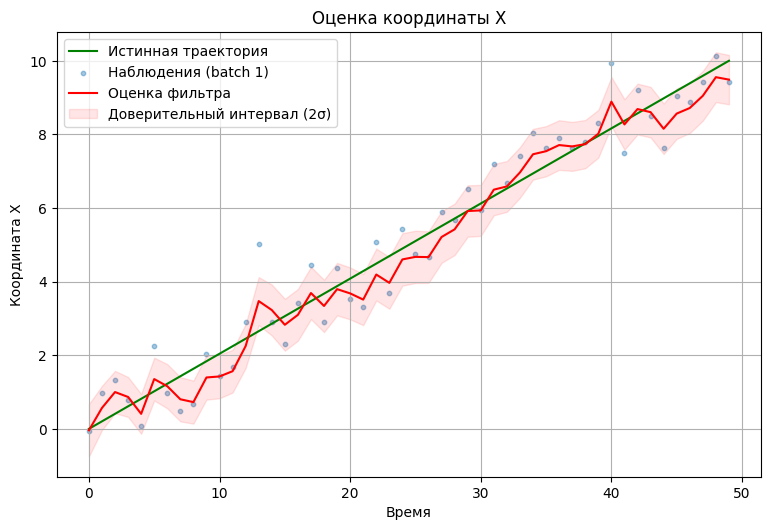

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 1. Инициализация фильтра
state_dim = 2  # x и y координаты
obs_dim = 1    # Наблюдаем только x координату

# Матрицы модели
F = torch.eye(state_dim)  # Процессная модель (простое движение)
H = torch.tensor([[1., 0.]])  # Наблюдаем только первую координату
Q = 0.1 * torch.eye(state_dim)  # Шум процесса
R_init = torch.eye(obs_dim) * 0.5  # Начальная ковариация наблюдений

vkf = VBKalmanFilter(
    process_matrix=F,
    measurement_matrix=H,
    process_noise=Q,
    initial_measurement_cov=R_init,
    rho=0.95
)

# 2. Генерация синтетических данных
T = 50  # Временных шагов
B = 1   # Количество траекторий

# Истинная траектория (движение с постоянной скоростью)
true_states = torch.zeros(T, state_dim)
true_states[:, 0] = torch.linspace(0, 10, T)  # x координата
true_states[:, 1] = 0.5  # y координата (постоянная)

# Шумные наблюдения
observations = true_states[:, :1] + torch.randn(T, obs_dim) * 0.8
observations = observations.unsqueeze(1).repeat(1, B, 1)  # (T, B, obs_dim)

# 3. Применение фильтра
with torch.no_grad():
    means, covs = vkf(observations)
    current_R = vkf.get_measurement_covariance()

# 4. Визуализация
plt.figure(figsize=(15, 10))

# График наблюдений и оценок
plt.subplot(2, 2, 1)
plt.title("Оценка координаты X")
plt.plot(true_states[:, 0].numpy(), 'g-', label='Истинная траектория')
for b in range(B):
    plt.scatter(range(T), observations[:, b, 0].numpy(), 
                s=10, alpha=0.4, label=f'Наблюдения (batch {b+1})')
plt.plot(means[:, 0, 0].numpy(), 'r-', label='Оценка фильтра')
plt.fill_between(
    range(T),
    means[:, 0, 0].numpy() - 2 * np.sqrt(covs[:, 0, 0, 0].numpy()),
    means[:, 0, 0].numpy() + 2 * np.sqrt(covs[:, 0, 0, 0].numpy()),
    color='r', alpha=0.1, label='Доверительный интервал (2σ)'
)
plt.xlabel("Время")
plt.ylabel("Координата X")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()